# A Big Dam Problem:
# Identifying critical landscapes around the globe that will be affected by future dam construction.
Contributors: Lauren Herwehe, University of Colorado, Boulder and Stephanie L. Shepherd, Auburn University

## We should give a dam

Many scientists believe we may be on the cusp of the sixth Mass Extinction in Earth’s history, due to human impact on the environment (1). Since the early 20th Century the majority of major rivers around the globe have been impounded or diverted to harness the power of water for energy production, transportation, flood control, water storage, and even recreation (2, 3). Although we as a society benefit greatly from the construction of these engineering marvels, dams have a dramatic impact on river ecosystems. A dam drastically slows water flow, trapping sediment, fish, and water upstream as the reservoir fills flooding the river valley. As a result both the river habitats and the riparian habitats are lost. Downstream of the dam water flow is strictly controlled, often eliminating the natural annual cycles of flooding that supplied sediment and nutrients to the floodplain. When water flow exceeds the storage capacity of the dam, the water released often causes catastrophic flooding downstream. Even as the water rushes out the necessary sediment, nutrients, and organisms are for the most part still trapped behind the dam. Finally dam construction alters the aesthetics of beautiful landscapes around the world and threatening freshwater and terrestrial species (4). Thousands of new dams are proposed globally that will potential impact protected areas such as National Parks, UNESCO World Heritage Sites, and Ramsar Sites adjacent to rivers.

This project is being undertaken in collaboration with the World Wildlife Foundation for the purpose of identifying critical habitats that will potentially be impacted by future dam construction through the analysis of existing datasets. 

## Gathering the Data
Various organizations and researchers have gathered information about our river around the globe that we have leveraged to identify protected areas that are downstream from proposed dams.  

### Free Flowing Rivers
This database contains hydrographic information for all major rivers across the globe. Of particular interest for this work is the Degree of Regulation (DOR) was calculated for each river reach in the database.  DOR is an index that represents how water storage behind a dam will impact the flow of river reaches downstream.  It is reported as a percent, where 0% is a free flowing river and 100% is a reach where the flow is completely altered by a dam.

https://www.nature.com/articles/s41586-019-1379-9
https://figshare.com/articles/Mapping_the_world_s_free-flowing_rivers_data_set_and_technical_documentation/7688801

### Current and Future Dam Database
Global Dam Watch, a collaboration between NGOs and academic institutions, has created and made publicly available three databases that document current and proposed large dams (capacity of >....)across the globe. http://globaldamwatch.org/data/
* Global Georeferenced Database of Dams (GOODD)
* Global Reservoir and Dam Database (GRanD)
* Future Hydropower Reservoirs and Dams (FHReD)

### World Database of Protected Areas
The World Database of Protected Areas (WDPA) is a global database of terrestrial and marine protected areas developed and curated by the International Union for the Conservation of Nature and the United Nations Environmental Programme. https://www.iucn.org/theme/protected-areas/our-work/quality-and-effectiveness/world-database-protected-areas-wdpa


## Asking the Right Questions

Pulling all these data sets together allows us to start asking where are new dams going to be built? And how many protected areas are close enough to these dams to potentially be affected? 

First we overlayed the river reaches (a segment of river channel between two junctions with other channels) that currently have some Degree of Regulation (DOR) with the protected areas (Figure 1). In order to compare the magnitude of regulation the data was divided into group - < 5%, 5-10%, 10-15%, 15-20%, and over 20%.  All river reaches with a DOR of 0% are excluded from these images. Then we hid all river reaches that did not correspond with a protected area (Figure 2). Finally we subtracted the current DOR value from the proposed dam DOR value to find out which areas would have an increase in regulation (Figure 3).

(We need to expand our explanation and possibly use fewer maps to illustrate the process, depends on what we decide to communicate. Do we want to include more of the process of data analysis, i.e. how to make the sausage)


In [1]:
# Imports
import warnings
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from geopandas import GeoSeries as gs
from shapely.geometry import Point, Polygon

import contextily as ctx
import earthpy as et
import earthpy.plot as ep
from earthpy import clip as cl

import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

In [2]:
# Check path and set working directory.
wd_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if os.path.exists(wd_path):
    os.chdir(wd_path)
else:
    print("Path does not exist")

In [8]:
# Download Data stored on figshare
# Free flowing rivers current DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273213")

# Free flowing rivers future DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273216")

# WDPA Africa
et.data.get_data(url="https://ndownloader.figshare.com/files/23354894")

# Ramsar Sites
et.data.get_data(url="https://ndownloader.figshare.com/files/22507082")

# Country boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")

# Continent boundaries 
et.data.get_data(url="https://ndownloader.figshare.com/files/23392280")

# Continent-country csv
et.data.get_data(url="https://ndownloader.figshare.com/files/23393756")

Extracted output to /home/jovyan/earth-analytics/data/earthpy-downloads/country-borders


'/home/jovyan/earth-analytics/data/earthpy-downloads/continent-country.csv'

In [4]:
# Custon Function 1
def all_pa_country(country_name, wdpa_polys, ramsar_polys):
    """ This function takes a country name, WDPA polygons, and Ramsar Polygons, and returns a multipolygon feature of 
    the World Database of Protected Areas merged with the ramsar areas for that country.

    Parameters
    ----------
    country_name: str
        Three letter country code for the country to be analyzed.
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected country.
    ramsar_polys: gdf
        The feature with the ramsar polygons for the selected country.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the country.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["PARENT_ISO"] == country_name]
    wdpa_polys = wdpa_polys[wdpa_polys["PARENT_ISO"] == country_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [5]:
# Open ramsar areas
ramsar_polys = gpd.read_file(os.path.join(
    "earthpy-downloads", "ramsar-site-data", "ramsar-boundaries",
    "features_publishedPolygon.shp"))

# Data cleaning - take only necessary ramsar columns and rename them to match WDPA datast
ramsar_polys = ramsar_polys[['iso3', 'geometry']]

try:
    ramsar_polys = ramsar_polys.rename(columns={"iso3": "PARENT_ISO"})
except:
    print('Column is already named PARENT_ISO')

In [9]:
# Open country borders & ISOs
country_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "country-borders",
                                             "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"))
continent_iso = pd.read_csv(os.path.join(wd_path, "earthpy-downloads",
                                         "continent-country.csv"))


In [10]:
# Open WDPA polygons
wdpa_africa_polys = gpd.read_file(os.path.join(wd_path,
                                               "earthpy-downloads", "WDPA_Africa", "WDPA_Africa.shp"))

In [11]:
# Open current DOR shapefiles
dor_0to5 = gpd.read_file(os.path.join(wd_path,
                                      "earthpy-downloads", "DOR_Binned", "DOR_0to5.shp"))
dor_5to10 = gpd.read_file(os.path.join(wd_path,
                                       "earthpy-downloads", "DOR_Binned", "DOR_5to10.shp"))
dor_10to15 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_10to15.shp"))
dor_15to20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_15to20.shp"))
dor_over20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_over20.shp"))

In [12]:
# Open planned DOR shapefiles
dor_pla_0to5 = gpd.read_file(os.path.join(wd_path,
                                          "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_0to5.shp"))
dor_pla_5to10 = gpd.read_file(os.path.join(wd_path,
                                           "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_5to10.shp"))
dor_pla_10to15 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_10to15.shp"))
dor_pla_15to20 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_15to20.shp"))
dor_pla_over20 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_over20.shp"))

In [13]:
# Data cleaning - take only the needed columns from WDPA dataset
wdpa_africa_polys = wdpa_africa_polys[[
    'NAME', 'DESIG', 'PARENT_ISO', 'geometry']]

In [14]:
# Get africa border for clipping
africa_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "continent-poly",
                                            "Africa.shp"))
# Get country border for plotting
bf_border = country_borders[country_borders['CNTRY_NAME'] == "Burkina Faso"]

In [15]:
# Reproject all data to  World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
wdpa_africa_polys = wdpa_africa_polys.to_crs('epsg:4087')
ramsar_polys = ramsar_polys.to_crs('epsg:4087')
country_borders = country_borders.to_crs('epsg:4087')
bf_border = bf_border.to_crs('epsg:4087')

# Get the combined WDPA & ramsar areas for Burkina Faso
wdpa_ramsar_bfa = all_pa_country('BFA', wdpa_africa_polys, ramsar_polys)

# Projecting rivers as a for loop
gdf_list = [dor_0to5, dor_5to10, dor_10to15, dor_15to20, dor_over20, dor_pla_0to5, dor_pla_5to10, dor_pla_10to15, 
            dor_pla_15to20, dor_pla_over20]
river_list_prj = []

for shp in gdf_list:
    new_shp = shp.to_crs('epsg:4087')
    river_list_prj.append(new_shp)

# Re-assign names based on list index
dor_0to5 = river_list_prj[0]
dor_5to10 = river_list_prj[1]
dor_10to15 = river_list_prj[2]
dor_15to20 = river_list_prj[3]
dor_over20 = river_list_prj[4]

dor_pla_0to5 = river_list_prj[5]
dor_pla_5to10 = river_list_prj[6]
dor_pla_10to15 = river_list_prj[7]
dor_pla_15to20 = river_list_prj[8]
dor_pla_over20 = river_list_prj[9]

In [16]:
# Clip to only get current rivers in BF
all_rivers_0to5_bfa = gpd.clip(dor_0to5, bf_border)
all_rivers_5to10_bfa = gpd.clip(dor_5to10, bf_border)
all_rivers_10to15_bfa = gpd.clip(dor_10to15, bf_border)
all_rivers_15to20_bfa = gpd.clip(dor_15to20, bf_border)
all_rivers_over20_bfa = gpd.clip(dor_over20, bf_border)

# Clip to only get proposed rivers in BF
all_rivers_pla_0to5_bfa = gpd.clip(dor_pla_0to5, bf_border)
all_rivers_pla_5to10_bfa = gpd.clip(dor_pla_5to10, bf_border)
all_rivers_pla_10to15_bfa = gpd.clip(dor_pla_10to15, bf_border)
all_rivers_pla_15to20_bfa = gpd.clip(dor_pla_15to20, bf_border)
all_rivers_pla_over20_bfa = gpd.clip(dor_pla_over20, bf_border)

In [17]:
# Buffer all river data by 1/10km to turn them from lines to polys for overlay function
river_list = [all_rivers_0to5_bfa, all_rivers_5to10_bfa, all_rivers_10to15_bfa, all_rivers_over20_bfa, 
              all_rivers_pla_0to5_bfa, all_rivers_pla_5to10_bfa, all_rivers_pla_10to15_bfa, all_rivers_pla_15to20_bfa, 
              all_rivers_over20_bfa]

for river in river_list:
    river['geometry'] = river.buffer(100)

In [18]:
# Overlay current rivers on protected areas for Burkina Faso
rivers_0to5_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_0to5_bfa, how='intersection')
rivers_5to10_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_5to10_bfa, how='intersection')
rivers_10to15_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_10to15_bfa, how='intersection')
rivers_15to20_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_15to20_bfa, how='intersection')
rivers_over20_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_over20_bfa, how='intersection')

# Overlay projected rivers on protected areas for Burkina Faso
rivers_pla_0to5_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_pla_0to5_bfa, how='intersection')
rivers_pla_5to10_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_pla_5to10_bfa, how='intersection')
rivers_pla_10to15_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_pla_10to15_bfa, how='intersection')
rivers_pla_15to20_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_pla_15to20_bfa, how='intersection')
rivers_pla_over20_bfa = gpd.overlay(
    wdpa_ramsar_bfa, all_rivers_pla_over20_bfa, how='intersection')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


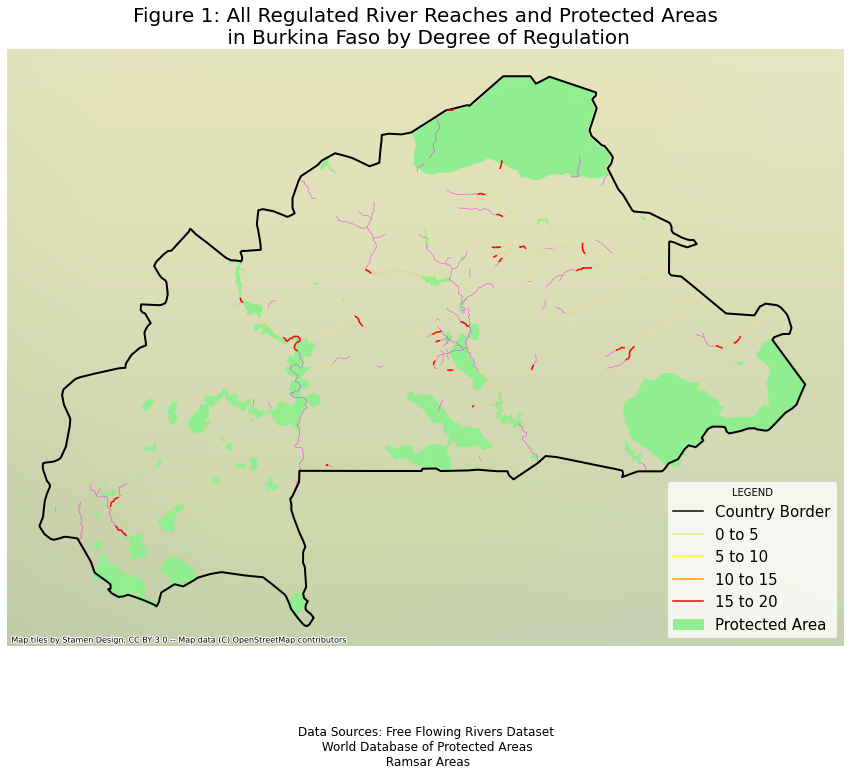

In [19]:
# figure 1 code, this will be hidden
# Plot all rivers (unclipped) and all protected areas for Burkina faso
fig, ax = plt.subplots(figsize=(15, 15))
wdpa_ramsar_bfa.plot(ax=ax, color="lightgreen")
all_rivers_0to5_bfa.plot(ax=ax,
                 markersize=15,
                 color='khaki', legend=True)
all_rivers_5to10_bfa.plot(ax=ax,
                  markersize=15,
                  color='yellow', legend=True)
all_rivers_10to15_bfa.plot(ax=ax,
                   markersize=15,
                   color='orange', legend=True)
all_rivers_15to20_bfa.plot(ax=ax,
                   markersize=15,
                   color='red', legend=True)
all_rivers_over20_bfa.plot(ax=ax,
                   markersize=15,
                   color='magenta', legend=True)
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
bf_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)

black_line = mlines.Line2D([], [], color='black', label='Country Border')
khaki_line = mlines.Line2D([], [], color='khaki', label='0 to 5')
yellow_line = mlines.Line2D([], [], color='yellow', label='5 to 10')
orange_line = mlines.Line2D([], [], color='orange', label='10 to 15')
red_line = mlines.Line2D([], [], color='red', label='15 to 20')
magenta_line = mlines.Line2D([], [], color='magenta', label='20 plus')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='Protected Area')

ax.set_title(
    'Figure 1: All Regulated River Reaches and Protected Areas\n in Burkina Faso by Degree of Regulation', size=20)
ax.set_axis_off()
ax.text(0.5, -0.2, "Data Sources: Free Flowing Rivers Dataset\n World Database of Protected Areas\n Ramsar Areas",
        size=12, ha="center", transform=ax.transAxes)
ax.legend(handles=[black_line, khaki_line, yellow_line, orange_line, red_line, lightgreen_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="LEGEND")

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


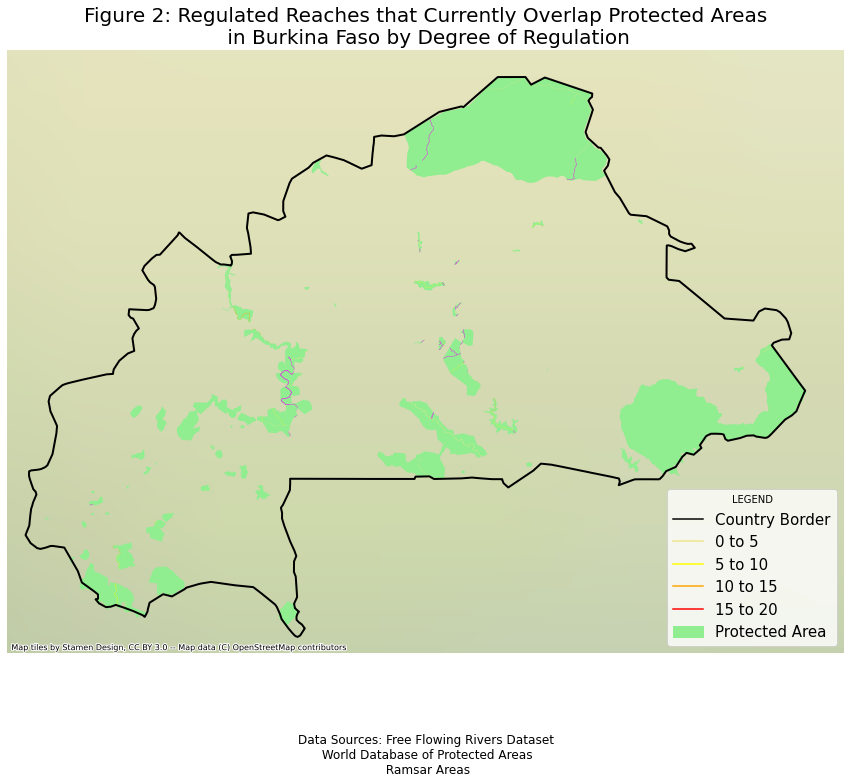

In [20]:
# figure 2 code, this will be hidden
# Create map of CURRENT rivers and protected areas for Burkina Faso
fig, ax = plt.subplots(figsize=(15, 25))

wdpa_ramsar_bfa.plot(ax=ax, color="lightgreen")
rivers_0to5_bfa.plot(ax=ax,
                 markersize=115,
                 color='khaki', legend=True)
rivers_5to10_bfa.plot(ax=ax,
                  markersize=15,
                  color='yellow', legend=True)
rivers_10to15_bfa.plot(ax=ax,
                   markersize=15,
                   color='orange', legend=True)
rivers_15to20_bfa.plot(ax=ax,
                   markersize=15,
                   color='red', legend=True)
rivers_over20_bfa.plot(ax=ax,
                   markersize=15,
                   color='magenta', legend=True)
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)

black_line = mlines.Line2D([], [], color='black', label='Country Border')
khaki_line = mlines.Line2D([], [], color='khaki', label='0 to 5')
yellow_line = mlines.Line2D([], [], color='yellow', label='5 to 10')
orange_line = mlines.Line2D([], [], color='orange', label='10 to 15')
red_line = mlines.Line2D([], [], color='red', label='15 to 20')
magenta_line = mlines.Line2D([], [], color='magenta', label='20 plus')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='Protected Area')
bf_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)

ax.set_title(
    'Figure 2: Regulated Reaches that Currently Overlap Protected Areas\n in Burkina Faso by Degree of Regulation', size=20)
ax.set_axis_off()
ax.text(0.5, -0.2, "Data Sources: Free Flowing Rivers Dataset\n World Database of Protected Areas\n Ramsar Areas",
        size=12, ha="center", transform=ax.transAxes)
ax.legend(handles=[black_line, khaki_line, yellow_line, orange_line, red_line, lightgreen_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="LEGEND")

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


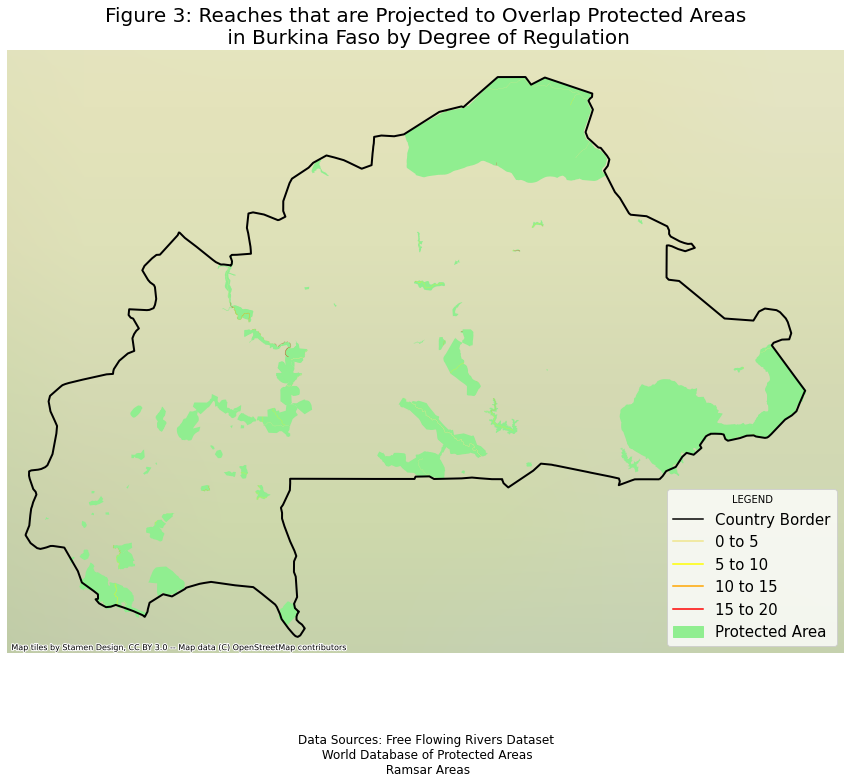

In [21]:
# Figure 3 code
# Create map of projected rivers and protected areas for Burkina Faso
fig, ax = plt.subplots(figsize=(15, 25))

wdpa_ramsar_bfa.plot(ax=ax, color="lightgreen")
rivers_pla_0to5_bfa.plot(ax=ax,
                 markersize=15,
                 color='khaki', legend=True)
rivers_pla_5to10_bfa.plot(ax=ax,
                  markersize=15,
                  color='yellow', legend=True)
rivers_pla_10to15_bfa.plot(ax=ax,
                   markersize=15,
                   color='orange', legend=True)
rivers_pla_15to20_bfa.plot(ax=ax,
                   markersize=15,
                   color='red', legend=True)
rivers_pla_over20_bfa.plot(ax=ax,
                   markersize=15,
                   color='magenta', legend=True)
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)

black_line = mlines.Line2D([], [], color='black', label='Country Border')
khaki_line = mlines.Line2D([], [], color='khaki', label='0 to 5')
yellow_line = mlines.Line2D([], [], color='yellow', label='5 to 10')
orange_line = mlines.Line2D([], [], color='orange', label='10 to 15')
red_line = mlines.Line2D([], [], color='red', label='15 to 20')
magenta_line = mlines.Line2D([], [], color='magenta', label='20 plus')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='Protected Area')
bf_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)

ax.set_title(
    'Figure 3: Reaches that are Projected to Overlap Protected Areas\n in Burkina Faso by Degree of Regulation', size=20)
ax.set_axis_off()
ax.text(0.5, -0.2, "Data Sources: Free Flowing Rivers Dataset\n World Database of Protected Areas\n Ramsar Areas",
        size=12, ha="center", transform=ax.transAxes)
ax.legend(handles=[black_line, khaki_line, yellow_line, orange_line, red_line, lightgreen_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="LEGEND")

In [22]:
# Graph 1 and 2 code 
# To support the next section we will add a graph that summarizes the total length of rivers that will be 
# impacted by new dams by continent.  And a graph that shows the total area of protected lands that will 
# potentially be impacted by new dams.


## What We Have Learned
For most countries there are only be a few protected areas that will potentially be affected by future dam construction.  #### (continent) has the greatest number of planned dams resulting in an increase in DOR along ?km of rivers that may impact ??? square kilometers of protected areas.

### For more information about this project, including the full code and data analysis, go to https://github.com/stephlshep/global-dam-impacts.

## References
1. Kolbert, E. 2014. The Sixth Extinction. New York: Henry Holt and Company. 320 p.
2. Graf, W.L. 2001. Damage Control: Restoring the Physical Integrity of America’s Rivers in The Annals of the Association of American Geographers, 91(1), p. 1-27.
3. Nilsson, C., Reidy, C.A., Dynesius, M., Revenga, C.. 2014. Fragmentation and Flow Regulation of the World’s Large River Systems in Science, 308(5720), p. 405-408. DOI: 10.1126/science.1107887
4. McAllister, D.E., Craig, J.F., Davidson, N., Delany, S., Seddon, M. 2001. Biodiversity Impacts of Large Dams. International Union for Conservation of Nature and Natural Resource and the United Nations Environmental Programme Report. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.392.9398&rep=rep1&type=pdf

## Contact:
Lauren Herwehe, Education Program Manager
Earth Lab
University of Colorado
Boulder, CO
Lauren.Herwehe@colorado.edu

Stephanie L. Shepherd, Assistant Professor
Dept. of Geosciences
Auburn University
Auburn, AL
slshepherd@auburn.edu